In [1]:
import numpy as np
import pylab as plt
plt.style.use('ggplot')
import astropy.units as au
import os

import gpflow as gp
from heterogp.latent import Latent
from gpflow import settings
import logging
logging.basicConfig(format='%(asctime)s %(message)s')
import tensorflow as tf



/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/multipledispatch-0.4.9-py3.6.egg/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Linear, NoneType, Sum, InducingPoints], [Gaussian, Identity, NoneType, Kernel, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


# Some helper functions

In [2]:
from gpflow.actions import Loop, Action
from gpflow.training import AdamOptimizer

class PrintAction(Action):
    def __init__(self, model, text):
        self.model = model
        self.text = text
        
    def run(self, ctx):
        likelihood = ctx.session.run(self.model.likelihood_tensor)
        logging.warning('{}: iteration {} likelihood {:.4f}'.format(self.text, ctx.iteration, likelihood))
#         logging.warning(self.model)
        
def run_with_adam(model, lr,iterations, callback=None):
    
    adam = AdamOptimizer(lr).make_optimize_action(model)
    
    actions = [adam]#natgrad,
    actions = actions if callback is None else actions + [callback]

    Loop(actions, stop=iterations)()
    model.anchor(model.enquire_session())

# Define some data with input-dependent noise

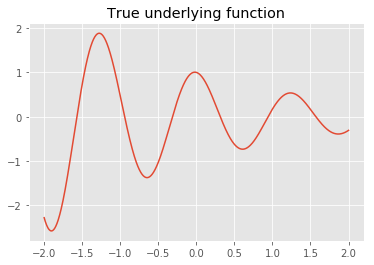

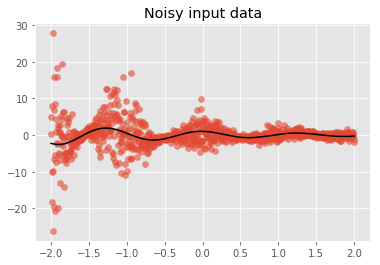

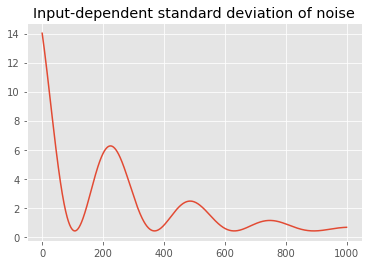

In [3]:
def func(X):
    return np.cos(5*X)*np.exp(-X/2)

N = 1000
X = np.linspace(-2,2,N)[:,None]
noise = 4*np.abs(0.25*(np.cos(6*X)+1)*np.exp(-X) + 0.1)
Y = func(X) + noise*np.random.normal(size=X.shape)

plt.plot(X[:,0],func(X)[:,0],alpha=1.)
plt.title("True underlying function")
plt.show()

plt.scatter(X[:,0],Y[:,0],alpha=0.6)
plt.plot(X[:,0],func(X)[:,0],alpha=1.,c='black')
plt.title("Noisy input data")
plt.show()
plt.title("Input-dependent standard deviation of noise")
plt.plot(noise)
plt.show()

# Vanilla solution

In [4]:
from gpflow.models import SVGP

settings.numerics.jitter_level=1e-6
iterations = 1000
Z = np.linspace(-2,2,100)[:,None]

with tf.Session(graph=tf.Graph()) as sess:
    with gp.defer_build():
        
        # Define the likelihood
        likelihood = gp.likelihoods.Gaussian()
        # Define the underlying GP mean and kernel
        mean = gp.mean_functions.Zero()
        kernel = gp.kernels.RBF(1)
        # Create the HGP (note the slightly different order from SVGP)
        model = SVGP(X, Y, kernel, likelihood, 
                     mean_function=mean, 
                     minibatch_size=100,
                     num_latent = 1, 
                     num_data=None,
                     whiten=False,
                    Z=Z)
        model.compile()
    
    run_with_adam(model,1e-3,iterations, PrintAction(model,"Adam"))
    # Predictions uses stochastic sampling and produces 
    # [num_samples,N,D] shape output
    ystar,varstar = model.predict_y(X)
    

2018-05-25 09:33:29,738 Adam: iteration 0 likelihood -44191663.2491
2018-05-25 09:33:29,869 Adam: iteration 1 likelihood -44019872.4162
2018-05-25 09:33:29,943 Adam: iteration 2 likelihood -43853479.1585
2018-05-25 09:33:30,003 Adam: iteration 3 likelihood -43690335.7714
2018-05-25 09:33:30,068 Adam: iteration 4 likelihood -43529208.7616
2018-05-25 09:33:30,133 Adam: iteration 5 likelihood -43371505.1215
2018-05-25 09:33:30,153 Adam: iteration 6 likelihood -43204957.1190
2018-05-25 09:33:30,178 Adam: iteration 7 likelihood -43051384.2982
2018-05-25 09:33:30,193 Adam: iteration 8 likelihood -42894457.1136
2018-05-25 09:33:30,265 Adam: iteration 9 likelihood -42740984.8441
2018-05-25 09:33:30,282 Adam: iteration 10 likelihood -42588500.2558
2018-05-25 09:33:30,302 Adam: iteration 11 likelihood -42438463.4866
2018-05-25 09:33:30,352 Adam: iteration 12 likelihood -42282170.1705
2018-05-25 09:33:30,370 Adam: iteration 13 likelihood -42133187.3487
2018-05-25 09:33:30,408 Adam: iteration 14 l

2018-05-25 09:33:33,698 Adam: iteration 119 likelihood -29714422.2757
2018-05-25 09:33:33,734 Adam: iteration 120 likelihood -29625053.5120
2018-05-25 09:33:33,757 Adam: iteration 121 likelihood -29524871.7542
2018-05-25 09:33:33,816 Adam: iteration 122 likelihood -29430112.0102
2018-05-25 09:33:33,832 Adam: iteration 123 likelihood -29337814.8426
2018-05-25 09:33:33,849 Adam: iteration 124 likelihood -29246214.0666
2018-05-25 09:33:33,887 Adam: iteration 125 likelihood -29151843.6551
2018-05-25 09:33:33,908 Adam: iteration 126 likelihood -29058876.5189
2018-05-25 09:33:33,942 Adam: iteration 127 likelihood -28969648.1085
2018-05-25 09:33:33,976 Adam: iteration 128 likelihood -28874044.8279
2018-05-25 09:33:33,990 Adam: iteration 129 likelihood -28782879.5538
2018-05-25 09:33:34,041 Adam: iteration 130 likelihood -28695452.1646
2018-05-25 09:33:34,086 Adam: iteration 131 likelihood -28606685.1881
2018-05-25 09:33:34,121 Adam: iteration 132 likelihood -28513678.9658
2018-05-25 09:33:34,

2018-05-25 09:33:36,985 Adam: iteration 237 likelihood -20556015.8176
2018-05-25 09:33:37,003 Adam: iteration 238 likelihood -20489233.7790
2018-05-25 09:33:37,017 Adam: iteration 239 likelihood -20424967.8074
2018-05-25 09:33:37,038 Adam: iteration 240 likelihood -20364352.0092
2018-05-25 09:33:37,062 Adam: iteration 241 likelihood -20301893.2402
2018-05-25 09:33:37,080 Adam: iteration 242 likelihood -20239200.1310
2018-05-25 09:33:37,094 Adam: iteration 243 likelihood -20178327.1894
2018-05-25 09:33:37,116 Adam: iteration 244 likelihood -20110716.3637
2018-05-25 09:33:37,128 Adam: iteration 245 likelihood -20050431.0598
2018-05-25 09:33:37,155 Adam: iteration 246 likelihood -19990207.3569
2018-05-25 09:33:37,187 Adam: iteration 247 likelihood -19928992.8769
2018-05-25 09:33:37,204 Adam: iteration 248 likelihood -19864501.2598
2018-05-25 09:33:37,448 Adam: iteration 249 likelihood -19801872.5290
2018-05-25 09:33:37,489 Adam: iteration 250 likelihood -19747587.4289
2018-05-25 09:33:37,

2018-05-25 09:33:40,711 Adam: iteration 355 likelihood -14281180.4199
2018-05-25 09:33:40,750 Adam: iteration 356 likelihood -14236188.9146
2018-05-25 09:33:40,765 Adam: iteration 357 likelihood -14189375.8514
2018-05-25 09:33:40,782 Adam: iteration 358 likelihood -14145358.7460
2018-05-25 09:33:40,822 Adam: iteration 359 likelihood -14100581.1032
2018-05-25 09:33:40,877 Adam: iteration 360 likelihood -14061046.0215
2018-05-25 09:33:40,903 Adam: iteration 361 likelihood -14017904.0673
2018-05-25 09:33:40,926 Adam: iteration 362 likelihood -13976584.5510
2018-05-25 09:33:40,951 Adam: iteration 363 likelihood -13930341.2607
2018-05-25 09:33:40,969 Adam: iteration 364 likelihood -13886773.1768
2018-05-25 09:33:40,993 Adam: iteration 365 likelihood -13844639.5698
2018-05-25 09:33:41,023 Adam: iteration 366 likelihood -13802480.5786
2018-05-25 09:33:41,047 Adam: iteration 367 likelihood -13757649.3888
2018-05-25 09:33:41,074 Adam: iteration 368 likelihood -13717013.8614
2018-05-25 09:33:41,

2018-05-25 09:33:44,467 Adam: iteration 473 likelihood -9903018.5646
2018-05-25 09:33:44,486 Adam: iteration 474 likelihood -9871482.6905
2018-05-25 09:33:44,538 Adam: iteration 475 likelihood -9841126.9280
2018-05-25 09:33:44,582 Adam: iteration 476 likelihood -9817357.7587
2018-05-25 09:33:44,620 Adam: iteration 477 likelihood -9782811.5224
2018-05-25 09:33:44,656 Adam: iteration 478 likelihood -9751200.9516
2018-05-25 09:33:44,688 Adam: iteration 479 likelihood -9718433.4697
2018-05-25 09:33:44,716 Adam: iteration 480 likelihood -9693768.6128
2018-05-25 09:33:44,753 Adam: iteration 481 likelihood -9659205.6131
2018-05-25 09:33:44,796 Adam: iteration 482 likelihood -9632499.3663
2018-05-25 09:33:44,836 Adam: iteration 483 likelihood -9601840.0234
2018-05-25 09:33:44,876 Adam: iteration 484 likelihood -9570292.0350
2018-05-25 09:33:44,925 Adam: iteration 485 likelihood -9544885.6127
2018-05-25 09:33:44,974 Adam: iteration 486 likelihood -9516125.5114
2018-05-25 09:33:45,009 Adam: iter

2018-05-25 09:33:48,667 Adam: iteration 592 likelihood -6836993.8732
2018-05-25 09:33:48,685 Adam: iteration 593 likelihood -6819051.2749
2018-05-25 09:33:48,700 Adam: iteration 594 likelihood -6792173.2709
2018-05-25 09:33:48,717 Adam: iteration 595 likelihood -6776636.2997
2018-05-25 09:33:48,734 Adam: iteration 596 likelihood -6751264.7807
2018-05-25 09:33:48,758 Adam: iteration 597 likelihood -6731271.6308
2018-05-25 09:33:48,779 Adam: iteration 598 likelihood -6713083.7985
2018-05-25 09:33:48,796 Adam: iteration 599 likelihood -6687971.5254
2018-05-25 09:33:48,817 Adam: iteration 600 likelihood -6665581.0096
2018-05-25 09:33:48,834 Adam: iteration 601 likelihood -6648791.0856
2018-05-25 09:33:48,853 Adam: iteration 602 likelihood -6626470.4298
2018-05-25 09:33:48,871 Adam: iteration 603 likelihood -6603295.9456
2018-05-25 09:33:48,888 Adam: iteration 604 likelihood -6584306.2685
2018-05-25 09:33:48,905 Adam: iteration 605 likelihood -6569332.7234
2018-05-25 09:33:48,925 Adam: iter

2018-05-25 09:33:51,780 Adam: iteration 711 likelihood -4719763.8667
2018-05-25 09:33:51,800 Adam: iteration 712 likelihood -4707550.2865
2018-05-25 09:33:51,826 Adam: iteration 713 likelihood -4688546.1350
2018-05-25 09:33:51,851 Adam: iteration 714 likelihood -4674428.3802
2018-05-25 09:33:51,872 Adam: iteration 715 likelihood -4661762.5833
2018-05-25 09:33:51,896 Adam: iteration 716 likelihood -4646017.3416
2018-05-25 09:33:51,908 Adam: iteration 717 likelihood -4631357.1125
2018-05-25 09:33:51,931 Adam: iteration 718 likelihood -4616306.1622
2018-05-25 09:33:51,951 Adam: iteration 719 likelihood -4600837.0315
2018-05-25 09:33:51,969 Adam: iteration 720 likelihood -4590053.8782
2018-05-25 09:33:51,993 Adam: iteration 721 likelihood -4573852.4794
2018-05-25 09:33:52,009 Adam: iteration 722 likelihood -4560322.9545
2018-05-25 09:33:52,032 Adam: iteration 723 likelihood -4545370.0565
2018-05-25 09:33:52,078 Adam: iteration 724 likelihood -4530258.9529
2018-05-25 09:33:52,119 Adam: iter

2018-05-25 09:33:55,001 Adam: iteration 830 likelihood -3269001.3896
2018-05-25 09:33:55,016 Adam: iteration 831 likelihood -3255489.2713
2018-05-25 09:33:55,037 Adam: iteration 832 likelihood -3245568.6247
2018-05-25 09:33:55,060 Adam: iteration 833 likelihood -3237014.4563
2018-05-25 09:33:55,079 Adam: iteration 834 likelihood -3226651.3187
2018-05-25 09:33:55,095 Adam: iteration 835 likelihood -3216560.7959
2018-05-25 09:33:55,116 Adam: iteration 836 likelihood -3205286.0902
2018-05-25 09:33:55,158 Adam: iteration 837 likelihood -3195668.3846
2018-05-25 09:33:55,196 Adam: iteration 838 likelihood -3186210.6098
2018-05-25 09:33:55,228 Adam: iteration 839 likelihood -3175455.7207
2018-05-25 09:33:55,251 Adam: iteration 840 likelihood -3169175.7039
2018-05-25 09:33:55,294 Adam: iteration 841 likelihood -3159419.1356
2018-05-25 09:33:55,337 Adam: iteration 842 likelihood -3149866.9432
2018-05-25 09:33:55,369 Adam: iteration 843 likelihood -3136435.8171
2018-05-25 09:33:55,403 Adam: iter

2018-05-25 09:33:58,338 Adam: iteration 949 likelihood -2270221.5844
2018-05-25 09:33:58,354 Adam: iteration 950 likelihood -2270196.9845
2018-05-25 09:33:58,368 Adam: iteration 951 likelihood -2262452.7812
2018-05-25 09:33:58,385 Adam: iteration 952 likelihood -2252444.7751
2018-05-25 09:33:58,399 Adam: iteration 953 likelihood -2243762.8364
2018-05-25 09:33:58,427 Adam: iteration 954 likelihood -2237239.9296
2018-05-25 09:33:58,446 Adam: iteration 955 likelihood -2229579.0390
2018-05-25 09:33:58,467 Adam: iteration 956 likelihood -2225967.5506
2018-05-25 09:33:58,479 Adam: iteration 957 likelihood -2219853.8312
2018-05-25 09:33:58,503 Adam: iteration 958 likelihood -2211188.2930
2018-05-25 09:33:58,522 Adam: iteration 959 likelihood -2204157.7222
2018-05-25 09:33:58,538 Adam: iteration 960 likelihood -2198723.4545
2018-05-25 09:33:58,557 Adam: iteration 961 likelihood -2194704.3938
2018-05-25 09:33:58,577 Adam: iteration 962 likelihood -2183191.2449
2018-05-25 09:33:58,602 Adam: iter

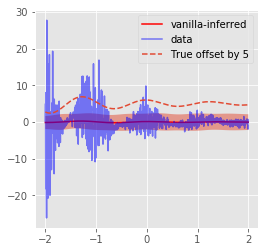

In [5]:
plt.figure(figsize=(4,4))
plt.plot(X[:,0],ystar,alpha=1,c='r',label='vanilla-inferred')
plt.fill_between(X[:,0],np.squeeze(ystar+np.sqrt(varstar)),
                 np.squeeze(ystar-np.sqrt(varstar)),
                 alpha=0.5)
plt.plot(X[:,0],Y[:,0],c='b',alpha=0.5,label='data')
plt.plot(X[:,0],func(X) + 5,ls='--',label='True offset by 5')
plt.legend()
# plt.title("Inferred solution on data")
plt.savefig("vanilla.png")
plt.show()

# Define the HGP model and train

We will:
  - Define the latent GP that models the noise
  - Define heteroscedastic likelihood which uses the above latent
  - Define the HGP which has another independent latent modelling the
  underlying function
  - Finally, train with Adam and plot the results

In [6]:
from heterogp.likelihoods import HeteroscedasticGaussian
from heterogp.hgp import HGP

settings.numerics.jitter_level=1e-6
iterations = 1000
Z = np.linspace(-2,2,100)[:,None]

with tf.Session(graph=tf.Graph()) as sess:
    with gp.defer_build():
        
        
        # Define the (log) noise latent
        mean = gp.mean_functions.Constant(np.log(0.5))
        kern = gp.kernels.RBF(1)
        log_noise_latent = Latent(Z, mean, kern, num_latent=1, whiten=False, name=None)
        # Define the likelihood
        likelihood = HeteroscedasticGaussian(log_noise_latent)
        log_noise_latent
        # Define the underlying GP mean and kernel
        mean = gp.mean_functions.Zero()
        kernel = gp.kernels.RBF(1)
        # Create the HGP (note the slightly different order from SVGP)
        model = HGP(X, Y, Z, kernel, likelihood, 
                     mean_function=mean, 
                     minibatch_size=500,
                     num_latent = 1, 
                     num_samples=1,
                     num_data=None,
                     whiten=False)
        model.compile()
    from timeit import default_timer
    t0 = default_timer()
    run_with_adam(model,1e-3,iterations)
    print(default_timer() - t0)
    # Predictions uses stochastic sampling and produces 
    # [num_samples,N,D] shape output
    ystar,varstar = model.predict_y(X, 100)
    # For plotting the noise
    hetero_noise = model.likelihood.compute_hetero_noise(X,100)

149.2886717620131


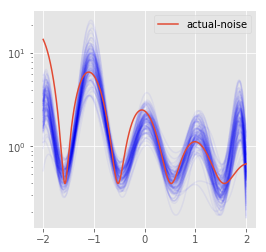

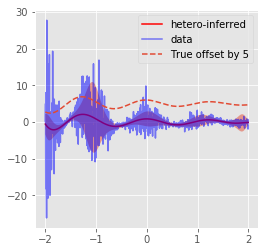

In [7]:
plt.figure(figsize=(4,4))
plt.plot(X[:,0],hetero_noise[:,:,0].T,alpha=0.05,c='b')
# plt.title("Samples for the noise latent")
plt.plot(X[:,0],noise,label='actual-noise')
plt.yscale('log')
plt.legend()
plt.savefig("inferred_noise.png")
plt.show()

plt.figure(figsize=(4,4))
plt.plot(X[:,0],ystar.mean(0),alpha=1,c='r',label='hetero-inferred')
plt.fill_between(X[:,0],np.squeeze(ystar.mean(0)+np.sqrt(varstar.mean(0))),
                 np.squeeze(ystar.mean(0)-np.sqrt(varstar.mean(0))),
                 alpha=0.5)
plt.plot(X[:,0],Y[:,0],c='b',alpha=0.5,label='data')
plt.plot(X[:,0],func(X) + 5,ls='--',label='True offset by 5')
plt.legend()
# plt.title("Inferred solution on data")
plt.savefig("hetero_inferred.png")
plt.show()